In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.svm import * 
from sklearn.model_selection import *
from imblearn.over_sampling import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from scipy.stats import t
from collections import defaultdict
import copy
import csv

# Data

## Preprocess
The German Risk data has 10 features, the features of the data are Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration and Purpose and the label of the data is called Risk. Since the features of the data are a mix of numerical and categorical values, it was necessary to transform the numerical values into a categorical one. First of all, age was transformed into a categorical variable by discriminating if an applicant is in retirement age or not. Second, credit amount of the loan was transformed into a categorical data by discriminating the continuous values by using quantiles. All values up to the 1st quantile are considered low, values in the interquartile range is considered medium, and values greater than the 3rd quantile to be considered high. Third, duration of the loan was transformed from a discrete numericla value into a categorical value by grouping all loans less than 12 months to be a short term loan, and anything greater than or equal to 12 months to be a long term loan. After transforming all the variables into a categorical variable, it was then possible to use dummy variables to model the levels of the categories. By encoding the cateogrical variable using the one hot encoding (dummy variable) method, the features grew from 9 columns up to 31 columns to encode all the possible combinations of the categorical variables. Subsequently, the data set was split into a 80% training and 20% testing set by simple random sample. This was employed to make sure that the test risk is an unbiased estimate of true risk. After the split it was found that the training set was imbalanced. In order to combat this, Synthetic Minority Over-sampling Technique (SMOTE) would be employed such that it would both oversample and undersample the training data in order to create a 50:50 balance. This would both exaggerate the minority and majority population of the training set and reduce estimation error due to bias.

In [172]:
filename='german_credit_data.csv'
df = pd.read_csv(filename,sep=',')

In [ ]:
df.head()

In [174]:
# pension age based on gender
pension = (df['Age'] >= 65) & (df['Sex'] == ('female')) | (df['Age'] >= 65) & (df['Sex'] == ('male'))

# discriminate based on quantiles of credit amount
df['Credit amount'].quantile([.25,.75])

credit = []
for i in df['Credit amount']:
    if i < df['Credit amount'].quantile(.25):
        credit.append('low')
    elif i < df['Credit amount'].quantile(.75):
        credit.append('med')
    else:
        credit.append('high')
# discriminate based on duration of loans in month if less than 12 then it's a short term loan, long term otherwise.

duration = []
for i in df['Duration']:
    if i < 12:
        duration.append('short')
    else:
        duration.append('long')

# clean whitespace on column names to not fuck shit up
df.columns = df.columns.str.replace(' ', '')
# create new dataframe
df_clean = pd.DataFrame(columns=['sex','housing','job','purpose','sav','chq','amt','duration','pension'])
df_clean = df_clean.fillna(0)

# factorize all categorical variables, take the log of credit amount because it's better to work in the log scale for money
df_clean['sex'] = pd.factorize(df.Sex)[0]
df_clean['housing'] = pd.factorize(df.Housing)[0]
df_clean['job'] = pd.factorize(df.Job)[0]
df_clean['purpose'] = pd.factorize(df.Purpose)[0]
df_clean['sav'] = pd.factorize(df.Savingaccounts)[0] + 1
df_clean['chq'] = pd.factorize(df.Checkingaccount)[0] + 1
df_clean['pension'] = pd.factorize(pension)[0]
df_clean['amt'] = pd.factorize(credit)[0]
df_clean['duration'] = pd.factorize(duration)[0]

# good risk = 0, bad risk = 1
label = pd.factorize(df["Risk"].values)[0]


In [175]:
df_clean.head()

,sex,housing,job,purpose,sav,chq,amt,duration,pension
0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,2,1,1,1
2,0,0,1,1,1,0,2,1,1
3,0,1,0,2,1,1,1,1,1
4,0,1,0,3,1,1,1,1,1


In [176]:
# in order to replicate the experiment
seed = 1992
# split data for training and holdout test set
data_train, data_test, label_train, label_test = train_test_split(df_clean, label, test_size = 0.20, random_state=seed)

# SMOTE to oversample and undersample
sm = SMOTE(random_state=seed)
data_train, label_train = sm.fit_resample(data_train, label_train)

# using stratified k fold in order to get equal proportion of data
skf = StratifiedKFold(n_splits=4, random_state=seed, shuffle=True)

# Training
## Methods
These five following classifiers are chosen to solve the task of binary classification: 

$h_1$: Logistic regression with a regularization parameter of 0.8 and the rest of the parameters are chosen as default. 


$h_2$: Support vector machines with a polynomial kernel of degree 2, the rest of the parameters are chosen by default.


$h_4$: Random forest with 6 trees with maximum depth equal to the number of features after adding the dummy variables were chosen as parameters of this algorithm. The maximum depth was chosen because the data was transformed to a purely categorical one, and the maximum depth of the tree will enable all permutations of the categorical variables to work. The rest of the parameters are chosen as default.


$h_5$: K Nearest Neighbor with $k=7$ and with default parameters for the rest.


$h_6$: Artifiicial Neural Network with a hidden layer, sigmoid activation function and Stochastic Gradient Descent to tune its weights as parameters. The rest of the hyper parameters are default values from the function itself.

## Crossvalidation

After preprocessing the data and finally achieving a train and test split, it is then possible to employ cross validation on the training set. Stratified k-fold is chosen in order to preserve the 50:50 balance of the training data. In this data, four folds were chosen and all the algorithms were run through each permutation of the folds of the data once. The best classifier score out of the four folds will determine the best model of each algorithm which will then be used on the testing set.

In [177]:
# ml models
l = LogisticRegression(C=0.8, random_state = seed, solver='liblinear')
r = RandomForestClassifier(n_estimators=6,max_depth=31, random_state= seed)
s = SVC(kernel='poly', degree=3, gamma=2, probability=True, random_state = seed)
k = KNeighborsClassifier(n_neighbors=7)
a = MLPClassifier(solver='sgd', activation='relu', alpha=1e-5,hidden_layer_sizes=(9,), random_state=seed)

# One hot encoding (dummy variables)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data_train)
X_train_one_hot = enc.transform(data_train)
X_test_one_hot = enc.transform(data_test)

X_train = []
X_test = []
y_train = []
y_test = []

# Stratified K-fold
for train_index, test_index in skf.split(X_train_one_hot, label_train):
    train_data, test_data = X_train_one_hot[train_index], X_train_one_hot[test_index]
    X_train.append(train_data)
    X_test.append(test_data)
    
    train_label, test_label = label_train[train_index], label_train[test_index]
    y_train.append(train_label)
    y_test.append(test_label)    

In [178]:
# testing 0 1 loss
l_test_error = [];
s_test_error = [];
r_test_error = [];
k_test_error = [];
a_test_error = [];
l_pred = []
s_pred = []
r_pred = []
k_pred = []
a_pred = []


for i in range(4):
    l.fit(X_train[i],y_train[i])
    s.fit(X_train[i],y_train[i])
    r.fit(X_train[i],y_train[i])
    k.fit(X_train[i],y_train[i])   
    a.fit(X_train[i],y_train[i])  

    l_pred.append(l.predict(X_test[i]))
    l_test_error.append(balanced_accuracy_score(y_test[i],l_pred[i]))
    s_pred.append(s.predict(X_test[i])) 
    s_test_error.append(balanced_accuracy_score(y_test[i],s_pred[i]))
    
    r_pred.append(r.predict(X_test[i]))
    r_test_error.append(balanced_accuracy_score(y_test[i],r_pred[i]))    
    k_pred.append(k.predict(X_test[i]))
    k_test_error.append(balanced_accuracy_score(y_test[i],k_pred[i]))  
    a_pred.append(a.predict(X_test[i]))
    a_test_error.append(balanced_accuracy_score(y_test[i],a_pred[i]))

index = []
index.append(l_test_error.index(max(l_test_error)))
index.append(s_test_error.index(max(s_test_error)))
index.append(r_test_error.index(max(r_test_error)))
index.append(k_test_error.index(max(k_test_error)))
index.append(a_test_error.index(max(a_test_error)))

/Users/clinton.ali/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clinton.ali/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clinton.ali/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/clinton.ali/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

In [179]:
l.fit(X_train[index[0]],y_train[index[0]])
s.fit(X_train[index[1]],y_train[index[1]])
r.fit(X_train[index[2]],y_train[index[2]])
k.fit(X_train[index[3]],y_train[index[3]])   
a.fit(X_train[index[4]],y_train[index[4]])  

l_test_pred = l.predict(X_test_one_hot)
s_test_pred = s.predict(X_test_one_hot)
r_test_pred = r.predict(X_test_one_hot)
k_test_pred = k.predict(X_test_one_hot)
a_test_pred = a.predict(X_test_one_hot)

empirical_risk = []

empirical_risk.append(zero_one_loss(label_test,l_test_pred))
empirical_risk.append(zero_one_loss(label_test,s_test_pred))
empirical_risk.append(zero_one_loss(label_test,r_test_pred))
empirical_risk.append(zero_one_loss(label_test,k_test_pred))
empirical_risk.append(zero_one_loss(label_test,a_test_pred))


m = X_test_one_hot.shape[0]

print(empirical_risk)

[0.275, 0.345, 0.31999999999999995, 0.345, 0.30000000000000004]


/Users/clinton.ali/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Analysis

## Empirical Risk
The empirical risk of each classifier were found to be as follows:
$L_S(h_1) = 0.275$  
$L_S(h_2) = 0.345$  
$L_S(h_3) = 0.320$  
$L_S(h_4) = 0.345$  
$L_S(h_5) = 0.300$  

## Hoeffding's Bound on Empirical Risk with a zero-one loss function
The Hoeffding's bounds were chosen because they offer a tighter bound compared to the usual methods. The confidence intervals were computed as follows:  

$P(|L_{S_{test}}(h_i) - L_S(h_i)|) \geq \sqrt{\frac{\log 2/\delta}{2m}}$ for  $i \in 1,2,3,5,4,6$


Where $m = 200$, or size of testing set.

Based on the one-at-time 95% and 99% confidence intervals, logistic regression was the classifier with the tightest upper bound on the empirical risk. However, based on both te 95% and 99% simultaneous confidence intervals, with equal weights given to each classifer, it is possible to conclude that there are no statistically significant difference between each classifier's empirical risk.

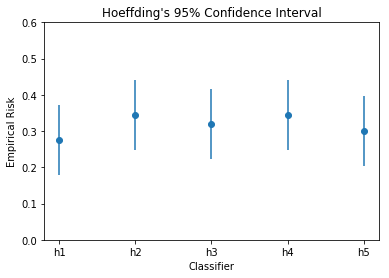

In [180]:
delta = 0.05
hoeffding = np.sqrt(float(np.log(2/delta))/(float(2)*m))
lower = empirical_risk - hoeffding
upper = empirical_risk + hoeffding
hoeffding_ci = [lower,upper]


plt.errorbar(["h1","h2","h3","h4","h5"], empirical_risk, yerr=hoeffding, linestyle='',fmt="o")
plt.title("Hoeffding's 95% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0,0.6])
plt.xlabel('Classifier')
plt.ylabel('Empirical Risk')
plt.show()


delta = 0.01
hoeffding = np.sqrt(float(np.log(2/delta))/(float(2)*m))
lower = empirical_risk - hoeffding
upper = empirical_risk + hoeffding
hoeffding_ci = [lower,upper]

plt.errorbar(["h1","h2","h3","h4","h5"], empirical_risk, yerr=hoeffding, linestyle='',fmt="o")
plt.title("Hoeffding's 99% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0,0.6])
plt.xlabel('Classifier')
plt.ylabel('Empirical Risk')
plt.show()

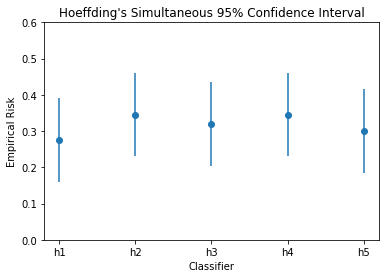

In [182]:
delta = 0.05/5
hoeffding = np.sqrt(float(np.log(2/delta))/(float(2)*m))
lower = empirical_risk - hoeffding
upper = empirical_risk + hoeffding
hoeffding_ci = [lower,upper]


plt.errorbar(["h1","h2","h3","h4","h5"], empirical_risk, yerr=hoeffding, linestyle='',fmt="o")
plt.title("Hoeffding's Simultaneous 95% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0,0.6])
plt.xlabel('Classifier')
plt.ylabel('Empirical Risk')
plt.show()

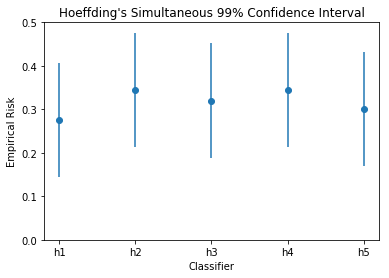

In [183]:
delta = 0.01/5
hoeffding = np.sqrt(float(np.log(2/delta))/(float(2)*m))
lower = empirical_risk - hoeffding
upper = empirical_risk + hoeffding
hoeffding_ci = [lower,upper]


plt.errorbar(["h1","h2","h3","h4","h5"], empirical_risk, yerr=hoeffding, linestyle='',fmt="o")
plt.title("Hoeffding's Simultaneous 99% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0,0.5])
plt.xlabel('Classifier')
plt.ylabel('Empirical Risk')
plt.show()

In [190]:
print(avg_prec)

[0.6493381076033974, 0.48666029635730507, 0.517364377081911, 0.529765792256989, 0.683813659258385]


## Average Precision Score
Precision and recall curve measures the ratio of true positives over the sum of true and negative
positives. However, the difficulty of assessing the curve itself has lend a way to using it's Average Precision Score. The higher the average precision score of a classifier, the better the classifier is at minimizing false positives. The average precision score of classifier $h_i$ will denoted as $APS(h_i)$.

The average precision score of each classifier are:
$APS(h_1) = 0.649$
$APS(h_2) = 0.487$
$APS(h_3) = 0.517$
$APS(h_4) = 0.530$
$APS(h_5) = 0.684$


## Bootstrap bounds on Average Precision Score

Since, the precision scores are unique according to each testing set. A method (Evans & Rosenthal, p. 355) devised to find the standard error by resampling from an empirical cumulative distribution function. Resamples are drawn with replacement on the testing data and then its average precision score is calculated. This process is repeated for $10^4$ times in order to generate an empirical distribution function and which in turn will generate a standard error. Then a studentized $\gamma$-confidence interval of the average precision score can be computed as follows:

$APS(h_i) \pm t_{(1+\gamma)/2}(n-1) \cdot \sqrt{Var(APS(h_i))}$ for $i = 1,2,3,4,5$

Based on the 95% and 99% confidence intervals, the neural network has the tightest lower bound on the average precision score. While on the simultaneous 95% confidence intervals, there is a clear separation between the average precision score of the single layer neural network and the support vector machine with polynomial kernel. However, at the simultaneous 99% confidence interval all the classifier's average precision score overlaps again.

In [184]:

avg_prec = []
avg_prec.append(average_precision_score(label_test,l.predict_proba(X_test_one_hot)[:,1]))
avg_prec.append(average_precision_score(label_test,s.predict_proba(X_test_one_hot)[:,1]))
avg_prec.append(average_precision_score(label_test,r.predict_proba(X_test_one_hot)[:,1]))
avg_prec.append(average_precision_score(label_test,k.predict_proba(X_test_one_hot)[:,1]))
avg_prec.append(average_precision_score(label_test,a.predict_proba(X_test_one_hot)[:,1]))


## bootstrap for confidence interval
n_bootstraps = 10000
bootstrap_prec = []
for i in range(5):
    bootstrap_prec.append([])

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(label_test) - 1, len(label_test))
    bootstrap_prec[0].append(average_precision_score(label_test[indices],l.predict_proba(X_test_one_hot[indices,])[:,1], pos_label = 0))
    bootstrap_prec[1].append(average_precision_score(label_test[indices],s.predict_proba(X_test_one_hot[indices,])[:,1], pos_label = 0))
    bootstrap_prec[2].append(average_precision_score(label_test[indices],r.predict_proba(X_test_one_hot[indices,])[:,1], pos_label = 0))
    bootstrap_prec[3].append(average_precision_score(label_test[indices],k.predict_proba(X_test_one_hot[indices,])[:,1], pos_label = 0))
    bootstrap_prec[4].append(average_precision_score(label_test[indices],a.predict_proba(X_test_one_hot[indices,])[:,1], pos_label = 0))

# get standard errors to build the t student confidence interval via bootstrapping
std_error = []
for i in range(5):
    std_error.append(np.sqrt(np.var(bootstrap_prec[i])))



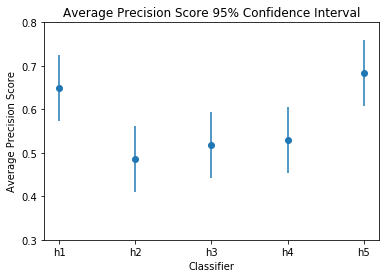

In [185]:
alpha = 0.05
t_stat = t.ppf((1-alpha+1)/2, df = n_bootstraps - 1)
upper_lower_bound = t_stat*std_error[0]

plt.errorbar(["h1","h2","h3","h4","h5"], avg_prec, yerr=upper_lower_bound, linestyle='',fmt="o")
plt.title("Average Precision Score 95% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0.3,0.8])
plt.xlabel('Classifier')
plt.ylabel('Average Precision Score')
plt.show()

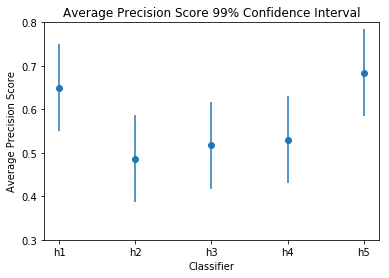

In [186]:
alpha = 0.01
t_stat = t.ppf((1-alpha+1)/2, df = n_bootstraps - 1)
upper_lower_bound = t_stat*std_error[0]

plt.errorbar(["h1","h2","h3","h4","h5"], avg_prec, yerr=upper_lower_bound, linestyle='',fmt="o")
plt.title("Average Precision Score 99% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0.3,0.8])
plt.xlabel('Classifier')
plt.ylabel('Average Precision Score')
plt.show()

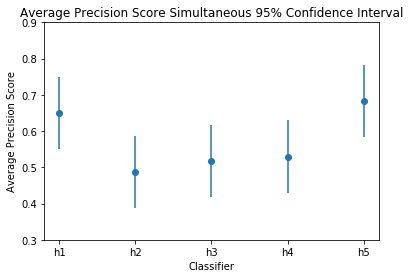

In [192]:
alpha = 0.05/5
t_stat = t.ppf((1-alpha+1)/2, df = n_bootstraps - 1)
upper_lower_bound = t_stat*std_error[0]

plt.errorbar(["h1","h2","h3","h4","h5"], avg_prec, yerr=upper_lower_bound, linestyle='',fmt="o")
plt.title("Average Precision Score Simultaneous 95% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0.3,0.9])
plt.xlabel('Classifier')
plt.ylabel('Average Precision Score')
plt.show()

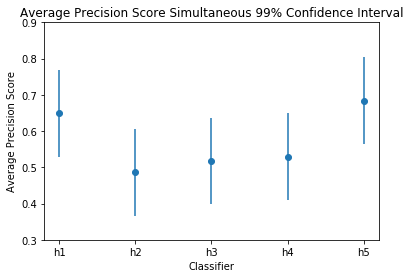

In [191]:
alpha = 0.01/5
t_stat = t.ppf((1-alpha+1)/2, df = n_bootstraps - 1)
upper_lower_bound = t_stat*std_error[0]

plt.errorbar(["h1","h2","h3","h4","h5"], avg_prec, yerr=upper_lower_bound, linestyle='',fmt="o")
plt.title("Average Precision Score Simultaneous 99% Confidence Interval")
axes = plt.gca()
axes.set_ylim([0.3,0.9])
plt.xlabel('Classifier')
plt.ylabel('Average Precision Score')
plt.show()



# Improvements
The biggest omission of this experiment is hyper parameter tuning. Since, all the parameters were chosen by inspecting the training errors directly, it may have been that the final parameters chosen are not optimal. For future runs of this experiment this can be implemented. However, all results of this experiment can be replicated by using the same seed on the supplementary code.

# Conclusion
Based on the zero one loss metric, it was discovered that there perhaps may not be a better classifier out of the five since the simultaneous confidence interval overlaps with each classifiers empirical risk. Also based on the average precision score, it was also discovered that at the boot-strap simultaneous 99% confidence interval there are no better classifier.  However, based on the tightest upper bound of the empirical risk, the logistic regression will be the classifier of choice for this run of the experiment.  While, based on the tightest lower bound of the average precision score, the single layer neural network will be the classifier of choice for this run of the experiment.